Multilayer Perceptrons and Backpropagation
===========================================

In [13]:

import scipy,pylab,numpy
from numpy import *
from scipy import *
from pylab import *
from urllib import urlopen
from gzip import GzipFile
from scipy.spatial import distance
from scipy.spatial.distance import cdist

# Nonlinear Classification Problem

Let's start by generating a simple linear non-classification problem.  Actually, this is a pretty simple problem as far as non-linear classification problems go: it's low dimensional, and the decision boundary is the combination of two axis aligned linear boundaries.  Still, it's a good way to get started.

In [14]:
data = random_sample((1000,2))
# labels = (data[:,0]**4 * 0.7+data[:,1]*0.4>0.3)
labels = ((data[:,0]-0.3) * (0.7-data[:,1]) > 0.0)
sum(labels)

607

In [15]:
def plotlabels():
    clf()
    d0 = data[labels==False]
    d1 = data[labels]
    plot(d0[:,0],d0[:,1],"bo")
    plot(d1[:,0],d1[:,1],"ro")
    savefig("tmp.png")
    print len(d0),len(d1)

393 607


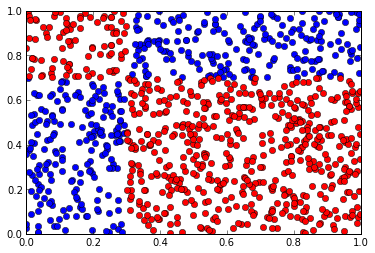

In [16]:
plotlabels()

Forward Step
==============

The function we use to predict the output from the neural network is two "layers" of linear discriminant functions with intervening sigmoid non-linearities.


$ y = \sigma(A x + a) $

$ z = \sigma(B y + b) $

The sigmoid function (applied element-wise) is defined as:

$\sigma(x) = \frac{1}{1+e^{-x}}$

In [17]:
def sigmoid(x):
    return 1/(1+exp(-x))
    
def forward(x):
    global A,a,B,b
    y = sigmoid(dot(A,x)+a)
    z = sigmoid(dot(B,y)+b)
    return z

Let's apply this, using randomly generated initial weights.



In [18]:
A = random(size=(5,2))-0.5
a = random(size=5)-0.5
B = random(size=(2,5))-0.5
b = random(size=2)-0.5

As output, we take an indicator vector as the target output.  For example, in a three class problem with output classes {0,1,2}, when the output class is 1, we require the MLP to output the vector [0,1,0].  This is also called a unary code.  Therefore, our network returns two values.



In [19]:
x = array([0.3,0.7])
forward(x)

array([ 0.43903366,  0.45311104])

The vector of outputs can be viewed as the outputs from a set of discriminant functions, so we identify the class as the maximum.



In [20]:
argmax(forward(x))

1

We can also treat the outputs as an approximation to a probability vector; in that case, we normalize the output.



In [21]:
z = forward(x)
z/sum(z)

array([ 0.49211037,  0.50788963])

We can plot either the posterior probabilities or the decision regions.



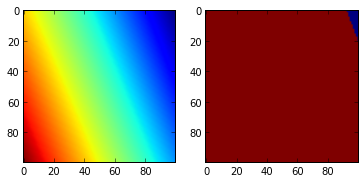

In [22]:
def plotgrid(f,dr=0):
    result = zeros((100,100))
    for i in range(100):
        for j in range(100):
            x = array([i/100.0,j/100.0])
            z = f(x)
            if dr==0:
                z /= sum(z)            
                result[i,j] = z[1]
            else:
                result[i,j] = argmax(z)
    imshow(result.T[::-1])
subplot(121); plotgrid(forward)
subplot(122); plotgrid(forward,dr=1)

# Backward Step

We start off with the total squared error.

$$ e = \sum_i (x_i - t_i)^2$$

We want to minimize that by changing the parameters $\theta = (A,a,B,b)$, so we
look for places where the partial derivatives vanish.

(Here, I use a shorthand of $\nabla_\theta z$ to stand for
the collection of partial derivatives with respect to the components of $\theta$.
This can be ambiguous at times, so if in doubt, work it out in components.)

$$ \nabla_\theta e = \sum_i 2(z_i-t_i) \frac{\partial z_i}{\partial \theta}$$

Now let's look at these components one-by-one.

$$ \nabla_\theta z_i = (\nabla_A z_i,\nabla_a z_i,\nabla_B z_i,\nabla_b z_i)$$

(second layer)

$$ \nabla_B e = \sum 2(z-t) \nabla_B z$$
$$ ~~~~~ = \sum 2(z-t) \sigma'(By+b) y^T$$
$$ ~~~~~ = \sum 2(z-t) z(1-z) y^T$$

$$ \nabla_b e = \sum 2(z-t) \nabla_b z$$
$$ ~~~~~ = \sum 2(z-t) \sigma'(By+b)$$
$$ ~~~~~ = \sum 2(z-t) z(1-z)$$

(first layer)

$$\nabla_A e = \sum 2(z-t)\nabla_A z$$
$$ ~~~~~ = \sum 2(z-t)\sigma'(By+b) B \nabla_A y$$
$$ ~~~~~ = \sum 2(z-t) z(1-z) B \sigma'(Ax+a) x^T$$
$$ ~~~~~ = \sum 2(z-t) z(1-z) B y(1-y) x^T$$

$$\nabla_a e = \sum 2(z-t)\nabla_a z$$
$$ ~~~~~ = \sum 2(z-t)\sigma'(By+b) B \nabla_a y$$
$$ ~~~~~ = \sum 2(z-t) z(1-z) B \sigma'(Ax+a)$$
$$ ~~~~~ = \sum 2(z-t) z(1-z) B y(1-y)$$

(deltas)

Now, let's write $\delta_z = 2(z-t) z(1-z)$

and

$\delta_y = 2(z-t) z(1-z) B y(y-1)$.

Then $\delta_y = \delta_z B y(y-y)$.

(backpropagation of deltas)

We obtain a general update rule:

- compute the $\delta$ for a layer by taking the $\delta$ from the
next layer and propagating it back by right multiplying with the
weight matrix connecting the two layers -- multiply it with the
activations for the previous layer to obtain the gradient

(gradient descent)

For gradient descent, we now use the standard update rule

$$\theta(t+1) = \theta(t) - \eta \nabla_\theta e$$

For _batch gradient descent_, we do this after summing up the total error.

For _stochastic gradient descent_, we compute the error gradient separately for each sample (or for a minibatch) and then update the parameters.

(derivative of the sigmoid function)

The derivative of the sigmoid function is:

$\sigma'(x) = -\frac{1}{(1+e^{-x})^2} e^{-x} (-1)$

$ ~~~~~ = \frac{e^{-x}}{(1+e^{-x})^2} = \frac{1}{1+e^{-x}} \frac{e^{-x}}{1+e^{-x}}$

We can relate this back to the value of the sigmoid function itself (this saves computation).

$ ~~~~~ = \sigma(x) (1-\sigma(x)) $

In [23]:
# Python implementation
def backward(x,target,eta):
    global A,a,B,b
    y = sigmoid(dot(A,x)+a)
    z = sigmoid(dot(B,y)+b)
    delta_z = 2*(z-target)*z*(1-z)
    delta_y = dot(delta_z,B)*y*(1-y)
    B -= eta * outer(delta_z,y)
    b -= eta * delta_z
    A -= eta * outer(delta_y,x)
    a -= eta * delta_y

In [24]:
# target array
targets = array([1-labels,labels]).T
targets[30:40]

array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1]])

In order to train on the input data, we need to perform multiple updates.



In [25]:
def update(steps,eta):
    for i in range(steps):
        index = randint(0,len(data))
        x = data[index]
        target = targets[index]
        backward(x,target,eta)

Before and after the updates.



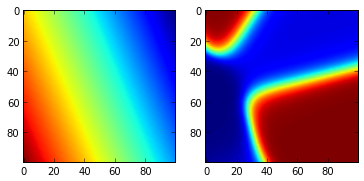

In [26]:
subplot(121); plotgrid(forward)
update(10000,1.0)
subplot(122); plotgrid(forward)

More updates.



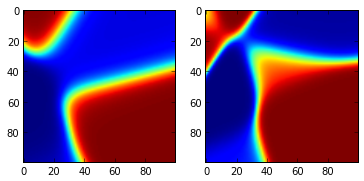

In [27]:
subplot(121); plotgrid(forward)
update(10000,1.0)
subplot(122); plotgrid(forward)

In [28]:

def plotclass():
    pred = zeros(len(data))
    for i in range(len(data)):
        z = forward(data[i])
        pred[i] = z[1]>z[0]
    cla()
    d0 = data[pred==0]
    d1 = data[pred==1]
    plot(d0[:,0],d0[:,1],"bo")
    plot(d1[:,0],d1[:,1],"ro")
    print "err=",sum(pred*1.0!=labels*1.0)/float(len(labels))

err= 0.076


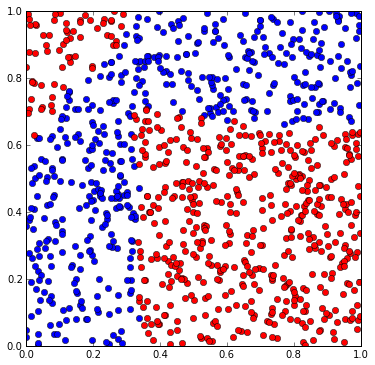

In [29]:
# plotting the classifications
figure(figsize=(6,6)); plotclass()

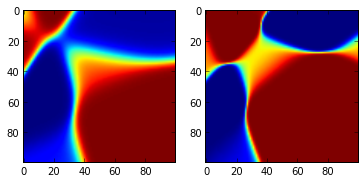

In [30]:
# more updates
subplot(121); plotgrid(forward)
update(100000,1.0)
subplot(122); plotgrid(forward)

err= 0.078


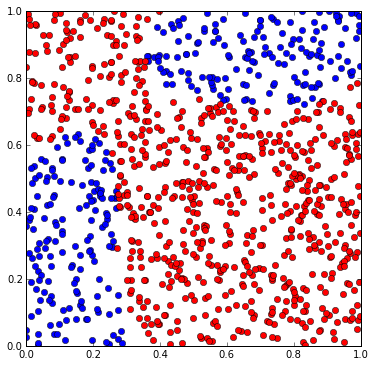

In [31]:
figure(figsize=(6,6)); plotclass()

Different Learning Rates
=========================

In the above examples, we just picked a learning rate of $\eta=1$.  That is often not the right learning rate.  In fact, with that learning rate and stochastic gradient decent, we have a limit on how well the algorithm can perform.  Effectively, a high learning rate means that the algorithm "forgets" earlier training examples quickly.  Eventually, to obtain better results from larger training sets, we need to decrease the learning rate.  That leads to better performance even in this case.

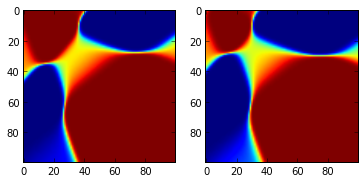

In [32]:
subplot(121); plotgrid(forward)
update(100000,0.1)
subplot(122); plotgrid(forward)

If the learning rate is too large, the stochastic gradient descent algorithm may diverge altogether.

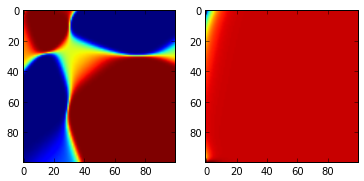

In [33]:
subplot(121); plotgrid(forward)
update(100000,10.0)
subplot(122); plotgrid(forward)

Different Number of Hidden Units
===================================

The minimum number of hidden units capable of solving this classification problem perfectly is 2.  However, that doesn't mean that 2 is the best number of units to use.  In fact, finding a good solution for the minimum number of units may be a computationally hard problem.  On the other hand, using "too many" hidden units may mean that the algorithm learns irrelevant detail from the training set (overtraining, see below).

In [34]:
def init(nhidden):
    global A,a,B,b
    A = random(size=(nhidden,2))-0.5
    a = random(size=nhidden)-0.5
    B = random(size=(2,nhidden))-0.5
    b = random(size=2)-0.5

err= 0.247


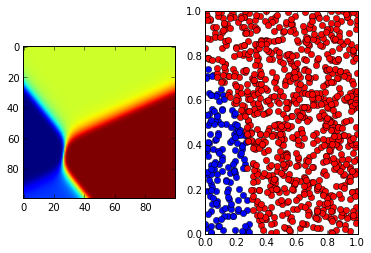

In [35]:
init(2)
update(100000,1.0)
subplot(121); plotgrid(forward)
subplot(122); plotclass()

err= 0.037


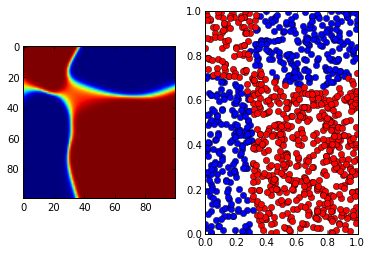

In [36]:
init(20)
update(100000,1.0)
subplot(121); plotgrid(forward)
subplot(122); plotclass()

err= 0.607


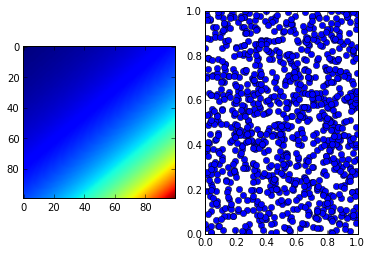

In [37]:
init(200)
update(100000,1.0)
subplot(121); plotgrid(forward)
subplot(122); plotclass()

Training Curves
===============

For actually training neural networks with stochastic gradient descent, it's useful to plot the error rate of predictions as the network is being trained.

In [38]:
def err():
    pred = zeros(len(data))
    for i in range(len(data)):
        z = forward(data[i])
        pred[i] = argmax(z)
    return sum(pred*1.0!=labels*1.0)/float(len(labels))

In [39]:
def training_curve(runs,updates,eta):
    errs = []
    for i in range(runs):
        e = err()
        errs.append(e)
        update(updates,eta)
    pylab.clf(); plot(range(len(errs)),errs); savefig("temp.png")
    return errs

0.058000000000000003

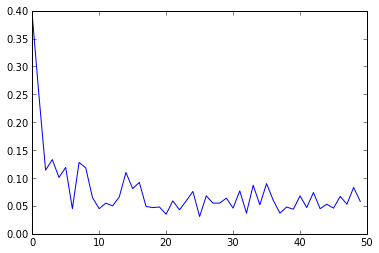

In [40]:
init(10)
training_curve(50,2000,1.0)[-1]

0.040000000000000001

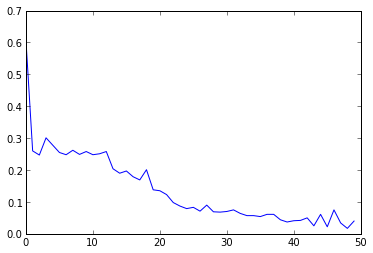

In [41]:
init(10)
training_curve(50,2000,0.1)[-1]

# Test Set Error

The problem we have been using has been quite easy: we have lots of training data and the classes are easily separated.  Also, we didn't look at the performance on new data.

Let us now change that.  Let's change the training set to contain 100 samples and then measure the performance on the remaining 900 samples (samples that the classifier hasn't seen).

In [42]:
if len(data)>100:
    test_data = data[100:]
    test_labels = labels[100:]
    data = data[:100]
    labels = labels[:100]

Using a smaller number of training samples seems to result in better performance... we're getting an error rate of (close to) 0.

0.0

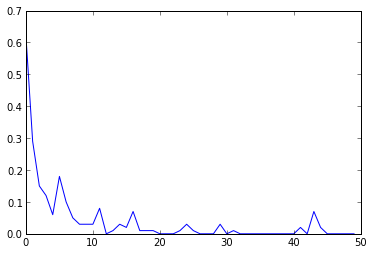

In [43]:
init(10)
training_curve(50,2000,1.0)[-1]

If we plot the classes, however, we can already see that the sparse samples simply can't contain enough information about the decision boundary: in the white, empty regions, the classifier simply doesn't know where to "draw" the decision boundary.

err= 0.0


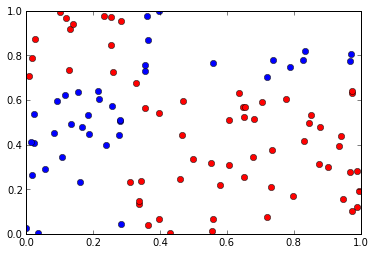

In [44]:
plotclass()

Let's now evaluate the error rate on previously unseen data.

In [45]:
def cv_err():
    pred = zeros(len(test_data))
    for i in range(len(test_data)):
        z = forward(test_data[i])
        pred[i] = argmax(z)
    return sum(pred*1.0!=test_labels*1.0)/float(len(test_labels))

In [46]:
cv_err()

0.054444444444444441

That's obviously much higher than the error rate on the training data.  So, performance on new data can be much worse than performance on the training data.

Let's look at this with training curves again.

In [47]:
def cv_training_curve(runs,updates,eta):
    errs = []
    cv_errs = []
    for i in range(runs):
        e = err()
        cv = cv_err()
        errs.append(e)
        cv_errs.append(cv)
        update(updates,eta)
    pylab.clf()
    plot(range(len(errs)),errs)
    plot(range(len(cv_errs)),cv_errs)
    savefig("temp.png")
    return errs

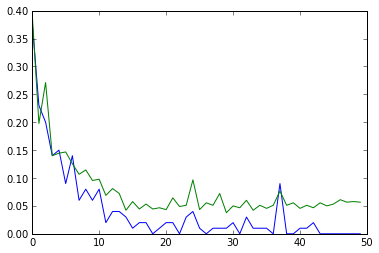

In [48]:
init(10)
_=cv_training_curve(50,2000,1.0)

What you can see here is that initially, both the error rate on the training data and the test set error rate decrase together.  However past the first six rounds of training, the test set error rate doesn't decrease any further, while the error rate on the training data keeps decreasing.  We call this _overtraining_.  

In this case, it would be a good idea to take the weights of the network not at 100000 update steps, but at around 12000.

err= 0.0


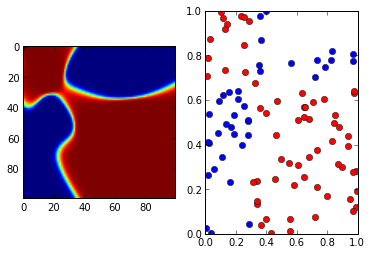

In [49]:
subplot(121); plotgrid(forward)
subplot(122); plotclass()

(cross-validation)

When we have limited amounts of data, we often perform _cross-validation_:

- partition the data $D$ into 10 separate subsets $T_i$ of about equal size
- train a classifier on $D - T_i$
- test the classifier on $T_i$ and compute the error rate $e_i$

Our estimate of the final error rate is the average of the error rates $e_i$.


(leave-one-out cross validation)

An extreme case of cross-validation is to train a model on each subset $D-\\{x_i\\}$ for $x_i\in D$ and average the resulting error rates.

This gives a good error estimate but is computationally very costly.

For some classifiers (e.g., nearest neighbor), leave-one-out cross-validation can be computed efficiently.

(observations)

- classifiers are prone to overtraining
- the more parameters a classifier has, the more likely it is to overtrain
- test set error is a better reflection of real-world performance than training set error
- cross-validation gives us better estimates of real-world error than a single test set

Keep in mind:

- if your test set is not representative (by accident or lack of randomization), your error rate estimates may be wildly wrong
- cross-validated error rates do not always converge asymptotically to the true error rate

# Test Set Error in the Presence of Errors

We introduced the notion of test set error in the case of fully separable data. The difference between training set and test set error becomes even more significant in the case of data that isn't fully separable.

In this case, the test set error rate simply stops changing after a while.  When the training data is noisier and there are a lot of hidden units, the cross-validated error rate can actually start increasing again.

Let's introduce some errors and see what happens (there is no guarantee that anything interesting happens).

In [50]:
labels = abs(labels-(random(len(labels))>0.9))
test_labels = abs(test_labels-(random(len(test_labels))>0.9))

38 62


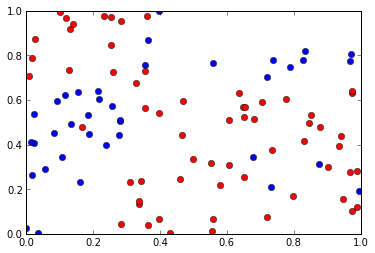

In [51]:
plotlabels()

Depending on whether we got lucky with the choice of data points, we may or may not observe the test set error rate curve going up again.



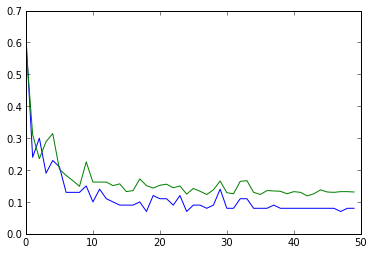

In [52]:
init(10)
_=cv_training_curve(50,2000,1.0)

err= 0.08


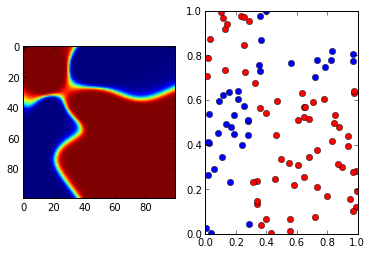

In [53]:
subplot(121); plotgrid(forward)
subplot(122); plotclass()